[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/07.dimensionality-reduction/b.svd-and-regression.ipynb)

# SINGULAR VALUE DECOMPOSITION AND REGRESSION

We will here explain how Singular Value Decomposition can be used as a pre-processing step for supervised learning tasks.

In [1]:
import numpy as np
import pandas as pd # For dataframes (tables)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

!pip install category_encoders
import category_encoders as ce

## Download the code I prepared for you
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/feature_engineering.py

from andrea_models import AndreaLinearRegression # In the course library

     |████████████████████████████████| 81kB 6.1MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--2021-05-17 00:53:46--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2021-05-17 00:53:46 (50.5 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2021-05-17 00:53:46--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/feature_engineering.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected

# Usual preprocessing

In [2]:
dataset_to_use = 'A'
mydatasets_folder = "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/"
filename = "df."+ dataset_to_use+"_2.csv"
complete_name = mydatasets_folder+filename
!wget $complete_name

--2021-05-17 00:53:47--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/df.A_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315832 (308K) [text/plain]
Saving to: ‘df.A_2.csv’

df.A_2.csv          100%[===================>] 308.43K  --.-KB/s    in 0.02s   

2021-05-17 00:53:47 (15.0 MB/s) - ‘df.A_2.csv’ saved [315832/315832]



In [3]:
df = pd.read_csv(complete_name)
df.head()

,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,BytesSent0,BytesReceived0,IPSrc1,IPDst1,Protocol1,PacketsSent1,PacketsReceived1,BytesSent1,BytesReceived1,IPSrc2,IPDst2,Protocol2,PacketsSent2,PacketsReceived2,BytesSent2,BytesReceived2,IPSrc3,IPDst3,Protocol3,PacketsSent3,PacketsReceived3,BytesSent3,BytesReceived3,IPSrc4,IPDst4,Protocol4,PacketsSent4,PacketsReceived4,BytesSent4,BytesReceived4,...,IPDst23,Protocol23,PacketsSent23,PacketsReceived23,BytesSent23,BytesReceived23,IPSrc24,IPDst24,Protocol24,PacketsSent24,PacketsReceived24,BytesSent24,BytesReceived24,IPSrc25,IPDst25,Protocol25,PacketsSent25,PacketsReceived25,BytesSent25,BytesReceived25,Buffering,Paused,Playing,CollectData,EpochTime,StartTime,PlaybackProgress,Length,BufferHealth,BufferProgress,BufferValid,KBytesReceived,label,label_num,KBytesReceived_log,PacketsSent_log,PacketsReceived_log,BytesSent_log,BytesReceived_log,BufferProgress_log
0,6.1,29,57,2372,79344,192.168.1.190,173.194.55.23,QUIC,29,57,2372,79344,192.168.1.190,172.217.11.3,0,0,0,0,0,192.168.1.190,172.217.6.225,0,0,0,0,0,192.168.1.190,172.217.11.35,0,0,0,0,0,192.168.1.190,172.217.12.174,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0.0.0,0,0,0,0,0,0,0,1,0,1520324868397,1520324862555,0.008,861.841,4.454,0.005177,True,79.344,q480p,480,4.373793,3.401197,4.060443,7.771910,11.281561,0.005164
1,5.8,7,39,625,52973,192.168.1.190,74.125.155.199,QUIC,4,36,384,50112,192.168.1.190,172.217.11.33,QUIC,2,2,159,1469,192.168.1.190,172.217.11.35,0,0,0,0,0,192.168.1.190,172.217.11.14,0,0,0,0,0,192.168.1.190,172.217.12.206,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0.0.0,0,0,0,0,0,0,0,1,0,1521147321127,1521147316421,0.007,817.841,3.955,0.004844,True,52.973,q360p,360,3.969782,2.079442,3.688879,6.439350,10.877557,0.004833
2,7.3,16,23,1056,34178,192.168.1.190,74.125.155.201,TCP,16,23,1056,34178,192.168.1.190,172.217.11.1,0,0,0,0,0,192.168.1.190,172.217.11.3,0,0,0,0,0,192.168.1.190,216.58.219.206,0,0,0,0,0,192.168.1.190,216.58.217.99,0,0,0,0,0,...,0,0,0,0,0,0,192.168.1.190,0,0,0,0,0,0,192.168.1.190,0.0.0.0,0,0,0,0,0,0,0,1,0,1516218797937,1516218790859,0.004,623.401,3.417,0.005488,True,34.178,q720p,720,3.531582,2.833213,3.178054,6.963190,10.439367,0.005473
3,39.2,14,29,3377,36821,192.168.1.190,172.217.135.40,0,0,0,0,0,192.168.1.190,173.194.184.73,QUIC,11,28,2257,36767,192.168.1.190,172.217.11.35,0,0,0,0,0,192.168.1.190,172.217.12.206,QUIC,2,0,1054,0,192.168.1.190,172.217.11.1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0.0.0,0,0,0,0,0,0,0,1,0,1521736968995,1521736937485,0.004,544.601,5.067,0.009311,True,36.821,q144p,144,3.606068,2.708050,3.401197,8.125039,10.513851,0.009268
4,4.6,9,77,900,104389,192.168.1.190,173.194.184.103,QUIC,9,77,900,104389,192.168.1.190,172.217.11.3,0,0,0,0,0,192.168.1.190,172.217.11.33,0,0,0,0,0,192.168.1.190,172.217.11.35,0,0,0,0,0,192.168.1.190,172.217.7.14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0.0.0,0,0,0,0,0,0,0,1,0,1521135591235,1521135586918,0.005,552.961,3.656,0.006621,True,104.389,q360p,360,4.648124,2.302585,4.356709,6.803505,11.555889,0.006599


In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 207 columns):
 #   Column               Dtype  
---  ------               -----  
 0   RelativeTime         float64
 1   PacketsSent          int64  
 2   PacketsReceived      int64  
 3   BytesSent            int64  
 4   BytesReceived        int64  
 5   IPSrc0               object 
 6   IPDst0               object 
 7   Protocol0            object 
 8   PacketsSent0         int64  
 9   PacketsReceived0     int64  
 10  BytesSent0           int64  
 11  BytesReceived0       int64  
 12  IPSrc1               object 
 13  IPDst1               object 
 14  Protocol1            object 
 15  PacketsSent1         int64  
 16  PacketsReceived1     int64  
 17  BytesSent1           int64  
 18  BytesReceived1       int64  
 19  IPSrc2               object 
 20  IPDst2               object 
 21  Protocol2            object 
 22  PacketsSent2         int64  
 23  PacketsReceived2     int64  
 24  Bytes

Remove the columns that are redundant or  that we cannot observe in a real network or we think are superflous.

In [5]:
cols_to_remove = list(["label", "EpochTime", "StartTime", "KBytesReceived"])
columns_we_cannot_observe = list(["Buffering", "Paused", "Playing", "CollectData",
              "PlaybackProgress", "Length", "BufferHealth", "BufferProgress", 
              "BufferValid"])
log_transformed_cols = list(df.columns[df.columns.str.contains('_log')] )
ip_address_cols  = list( df.columns[df.columns.str.contains('IP')] )
cols_to_remove += columns_we_cannot_observe
cols_to_remove += log_transformed_cols
cols_to_remove += ip_address_cols
print("Removing the following columns: ", cols_to_remove)

df = df.drop(cols_to_remove, axis=1)
df.info(verbose=True)

Removing the following columns:  ['label', 'EpochTime', 'StartTime', 'KBytesReceived', 'Buffering', 'Paused', 'Playing', 'CollectData', 'PlaybackProgress', 'Length', 'BufferHealth', 'BufferProgress', 'BufferValid', 'KBytesReceived_log', 'PacketsSent_log', 'PacketsReceived_log', 'BytesSent_log', 'BytesReceived_log', 'BufferProgress_log', 'IPSrc0', 'IPDst0', 'IPSrc1', 'IPDst1', 'IPSrc2', 'IPDst2', 'IPSrc3', 'IPDst3', 'IPSrc4', 'IPDst4', 'IPSrc5', 'IPDst5', 'IPSrc6', 'IPDst6', 'IPSrc7', 'IPDst7', 'IPSrc8', 'IPDst8', 'IPSrc9', 'IPDst9', 'IPSrc10', 'IPDst10', 'IPSrc11', 'IPDst11', 'IPSrc12', 'IPDst12', 'IPSrc13', 'IPDst13', 'IPSrc14', 'IPDst14', 'IPSrc15', 'IPDst15', 'IPSrc16', 'IPDst16', 'IPSrc17', 'IPDst17', 'IPSrc18', 'IPDst18', 'IPSrc19', 'IPDst19', 'IPSrc20', 'IPDst20', 'IPSrc21', 'IPDst21', 'IPSrc22', 'IPDst22', 'IPSrc23', 'IPDst23', 'IPSrc24', 'IPDst24', 'IPSrc25', 'IPDst25']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 136 columns):
 # 

One-hot encode all the columns relative to protocol

In [6]:
protocol_columns =  df.columns[df.columns.str.contains('Protocol')]
print("The columns concerning protocols are ", protocol_columns)

encoder = ce.OneHotEncoder(cols=protocol_columns, use_cat_names=True)
df = encoder.fit_transform(df)
df.head()

The columns concerning protocols are  Index(['Protocol0', 'Protocol1', 'Protocol2', 'Protocol3', 'Protocol4',
       'Protocol5', 'Protocol6', 'Protocol7', 'Protocol8', 'Protocol9',
       'Protocol10', 'Protocol11', 'Protocol12', 'Protocol13', 'Protocol14',
       'Protocol15', 'Protocol16', 'Protocol17', 'Protocol18', 'Protocol19',
       'Protocol20', 'Protocol21', 'Protocol22', 'Protocol23', 'Protocol24',
       'Protocol25'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,Protocol0_QUIC,Protocol0_TCP,Protocol0_0,Protocol0_TLSv1.2,Protocol0_UDP,PacketsSent0,PacketsReceived0,BytesSent0,BytesReceived0,Protocol1_0,Protocol1_QUIC,Protocol1_TCP,Protocol1_TLSv1.2,Protocol1_TLSv1,PacketsSent1,PacketsReceived1,BytesSent1,BytesReceived1,Protocol2_0,Protocol2_QUIC,Protocol2_TCP,PacketsSent2,PacketsReceived2,BytesSent2,BytesReceived2,Protocol3_0,Protocol3_QUIC,Protocol3_TLSv1.2,Protocol3_TCP,PacketsSent3,PacketsReceived3,BytesSent3,BytesReceived3,Protocol4_0,Protocol4_QUIC,...,PacketsSent18,PacketsReceived18,BytesSent18,BytesReceived18,Protocol19_0.0,PacketsSent19,PacketsReceived19,BytesSent19,BytesReceived19,Protocol20_0.0,PacketsSent20,PacketsReceived20,BytesSent20,BytesReceived20,Protocol21_0.0,PacketsSent21,PacketsReceived21,BytesSent21,BytesReceived21,Protocol22_0.0,PacketsSent22,PacketsReceived22,BytesSent22,BytesReceived22,Protocol23_0.0,PacketsSent23,PacketsReceived23,BytesSent23,BytesReceived23,Protocol24_0.0,PacketsSent24,PacketsReceived24,BytesSent24,BytesReceived24,Protocol25_0.0,PacketsSent25,PacketsReceived25,BytesSent25,BytesReceived25,label_num
0,6.1,29,57,2372,79344,1,0,0,0,0,29,57,2372,79344,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,480
1,5.8,7,39,625,52973,1,0,0,0,0,4,36,384,50112,0,1,0,0,0,2,2,159,1469,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,360
2,7.3,16,23,1056,34178,0,1,0,0,0,16,23,1056,34178,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,720
3,39.2,14,29,3377,36821,0,0,1,0,0,0,0,0,0,0,1,0,0,0,11,28,2257,36767,1,0,0,0,0,0,0,0,1,0,0,2,0,1054,0,1,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,144
4,4.6,9,77,900,104389,1,0,0,0,0,9,77,900,104389,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,360


Note that for the protocols of the least important connections (for instance `Protocol25_0.0`, the protocol of the least important connection), only 0.0 value exists. This means there is no traffic for such connections, for all the samples. In other words, there are no such connections.

In [7]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=19)

X_train = df_train.drop("label_num", axis=1)
y_train = df_train["label_num"]

X_test = df_test.drop("label_num", axis=1)
y_test = df_test["label_num"]

# Linear regression on the original dataset

In [8]:
model = AndreaLinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
RMSE

286943.98490848707

# Linear regression on the reduced dataset

### Introduction

We have learned that Singular Value Decomposition allows us to represent a dataset with few components intsead of all the features. 

We can interpret this by saying that we "project" each sample in a reduced vectorial space, whose dimension is the number of components < number of original features.

The idea of [Principal Component Regression](https://en.wikipedia.org/wiki/Principal_component_regression) consists in train a model on the "reduced" dataset, with only $k$ components instead of all the original features. It can be applied to any supervised task, not only a regression.

By doing so, it is likely the obtained model is more stable, since the reduced dataset only contain the important information, the noise is washed out. Therefore, there is less risk of overfitting.

Observe that
* Suppose your data matrix $\mathbf{A}$ (without labels), you apply Singular value decomposition and find $\mathbf{A}=\mathbf{U}\cdot\mathbf{\Sigma}\cdot\mathbf{V}^T$.
* We can approximate $\mathbf{A}\simeq\mathbf{U}_k\cdot\mathbf{\Sigma}_k\cdot\mathbf{V}_k^T$, where $k$ is the number of components we want to keep.
* It can be shown that, for any sample $\mathbf{x}$, its projection into the "reduced" vectorial space is $\tilde{\mathbf{x}}=\mathbf{x}^T\cdot \mathbf{V}_k$ (see "Derived covariates" in [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_regression) to know more).


Whenever we want to solve a supervised learning task, we can proceed as follows:
* Perform Singular Value Decomposition on the training set $\mathbf{A}^\text{train}=\mathbf{U}\cdot\mathbf{\Sigma}\cdot\mathbf{V}^T$
* Compute the reduced training data matrix $\tilde{\mathbf{A}}^\text{train}$, multiplying every sample (row of $\mathbf{A}^\text{train}$) by $\mathbf{V}_k$, i.e.
$$ \tilde{\mathbf{A}}^\text{train} = \mathbf{A}^\text{train} \cdot \mathbf{V}_k  $$
* Train your supervised model $h(\mathbf{x})$ on the reduced $\tilde{\mathbf{A}}^\text{train}$ instead of the original $\mathbf{A}^\text{train}$
* When a test sample $\mathbf{x}^\text{new}$ comes, project it into the reduced space, i.e., $\tilde{\mathbf{x}}^\text{new}=\mathbf{x}^\text{new}\cdot \mathbf{V}_k$.
* Find the label as $h(\tilde{\mathbf{x}}^\text{new})$.

We will now use the training set (only the features, without the label) to find the important "components" of our problem, where most of the information is concentrated. 

Then, to perform prediction on the test set, we will first project it on such components.

### Hands-on
Since the columns of our dataset have different magnitudes, we will perform standard scaling

In [9]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train)

**Perform Singular Value Decomposition** on the features of the scaled training set

In [10]:
U,Sigma,Vt = np.linalg.svd(X_train_sca)

**Decide how many components** you want to keep. To this aim, visualize the singular values.


Text(0.5, 1.0, 'Singular Values of X_train')

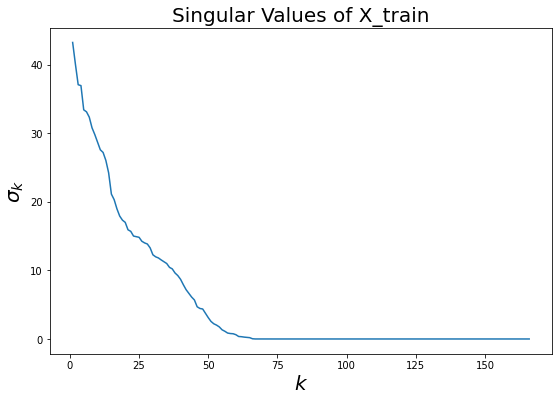

In [11]:
### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(Sigma)),Sigma)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
plt.title(r'Singular Values of X_train',size=20)

Let us also plot the percentage of variance captured by each component

In [12]:
s_squared = np.square(s)
total_variance = sum(s_squared)

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(s_squared)),s_squared/total_variance)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'Normalized variance explained',size=20)
plt.title(r'Normalized variance explained of X_train',size=20)

NameError: ignored

Let us plot the variance we capture when we keep $k$ components

In [ ]:
cumul = [ sum(s_squared[0:i]/total_variance) for i in range(len(s))]

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(cumul)),cumul)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'Cumulative normalized variance explained',size=20)
plt.grid(b=True)
plt.title(r'Cumulative normalized variance explained of X_train',size=20)

More on relation between singular values of the data matrix and the variance explained [here](https://genomicsclass.github.io/book/pages/svd.html).

From the plots it is clear we can just keep 50 components.

In [ ]:
k=50

**Compute the reduced training set**

In [ ]:
V = Vt.T # We are interested in V (while Vt is the transpose of V)
V_k = V[:, :k]
X_train_reduced = X_train_sca.dot(V_k)

**Fit a linear model** on the reduced training set

In [ ]:
model = AndreaLinearRegression()
model.fit(X_train_reduced, y_train)


We can now use this model to make prediction on the reduced test set.


**Project the test samples onto the reduced vectorial space**

**Make the prediction** on the reduced samples.

In [ ]:
X_test_sca = scaler.transform(X_test)
X_test_reduced = X_test_sca.dot (V_k)

In [ ]:
y_pred = model.predict(X_test_reduced)

MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
RMSE

Much better!